# Data Analysis and Preprocessing Notebook

This notebook is used to preprocess the data and perform exploratory data analysis.

In [23]:
import calendar
from pathlib import Path

import holidays
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

# Read Data from Parquet File

In [24]:
categories = pd.read_parquet("input_data/categories.parquet")
train = pd.read_parquet("input_data/train.parquet")
test = pd.read_parquet("input_data/test.parquet")

print("Unique identifiers in train set:", train["identifier"].nunique())
print("Unique identifiers in test set: ", test["identifier"].nunique())

train = train.merge(categories, on="identifier", how="left")
test = test.merge(categories, on="identifier", how="left")

print("Unique categories in train set: ", train["category"].nunique())
print("Unique categories in test set:  ", test["category"].nunique())

print("categories:", categories.shape)
print("train:", train.shape)
print("test:", test.shape)
print(train.head())

Unique identifiers in train set: 2837
Unique identifiers in test set:  2163
Unique categories in train set:  36
Unique categories in test set:   34
categories: (2832, 2)
train: (502258, 5)
test: (2163, 4)
   identifier        date  n_sold is_discounted    category
0  ff0cf47d18  2024-05-03       1          True  1f9e083420
1  ff0cf47d18  2024-05-17       1         False  1f9e083420
2  ff0cf47d18  2024-05-27       0         False  1f9e083420
3  ff0cf47d18  2024-05-29       0         False  1f9e083420
4  ff0cf47d18  2024-05-30       0         False  1f9e083420


# Check data integrity

In [25]:
# Check whether there are any identifiers in test that are not in train
test_only_identifiers = set(test.identifier.unique()) - set(train.identifier.unique())
print(f"Number of identifiers in test but not in train: {len(test_only_identifiers)}")

# Check whether there are any time periods in test that are not strictly later than all dates in train
min_train_date = train["date"].min()
max_train_date = train["date"].max()
test_period_start = test["period_start"].min()
test_period_end = test["period_end"].min()
print(f"Min train date: {min_train_date}")
print(f"Max train date: {max_train_date}")
print(f"Min test date:  {test_period_start}")
print(f"Max test date:  {test_period_end}")

Number of identifiers in test but not in train: 0
Min train date: 2024-05-01
Max train date: 2025-04-30
Min test date:  2025-05-01
Max test date:  2025-05-07


In [26]:
# Remove from the training set all identifiers belonging to categories that are not in the test set
train = train.drop(train[~train["category"].isin(test["category"])].index)
print("Unique categories in train set: ", train["category"].nunique())
print("Unique identifiers in train set:", train["identifier"].nunique())

Unique categories in train set:  34
Unique identifiers in train set: 2835


In [27]:
# Find identifiers with NaN category in train or test
train_no_category = train[train["category"].isna()]["identifier"].unique()
test_no_category = test[test["category"].isna()]["identifier"].unique()
print(f"Number of identifiers in train with no category: {len(train_no_category)}")
print(f"Number of identifiers in test with no category: {len(test_no_category)}")

# Assign identifiers with no category in one dataset the category of the same identifier in the other dataset
# If an identifier has no category in both datasets, assign it "unknown"
all_no_category = set(train_no_category) | set(test_no_category)
for identifier in all_no_category:
    train_cat = train.loc[
        (train["identifier"] == identifier) & (train["category"].notna()), "category"
    ]
    test_cat = test.loc[
        (test["identifier"] == identifier) & (test["category"].notna()), "category"
    ]
    if not train_cat.empty:
        category_value = train_cat.iloc[0]
    elif not test_cat.empty:
        category_value = test_cat.iloc[0]
    else:
        category_value = "unknown"
    train.loc[
        (train["identifier"] == identifier) & (train["category"].isna()), "category"
    ] = category_value
    test.loc[
        (test["identifier"] == identifier) & (test["category"].isna()), "category"
    ] = category_value

Number of identifiers in train with no category: 5
Number of identifiers in test with no category: 4


# Add date features

In [28]:
df = train.copy()
df["date"] = pd.to_datetime(df["date"])

# Custom week calculation: week 1 starts from Wednesday, May 1st, 2024
week1_start = pd.Timestamp("2024-05-01")
df["week"] = ((df["date"] - week1_start).dt.days // 7 + 1).clip(lower=1)

# Add is_holiday column based on Swedish public holidays
swedish_holidays = pd.Series(
    holidays.Sweden(include_sundays=False, years=df["date"].dt.year.unique())
)
df["is_holiday"] = df["date"].astype("datetime64[ns]").isin(swedish_holidays.index)

C:\Users\Dealan\AppData\Local\Temp\ipykernel_7136\2914175120.py:12: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df["is_holiday"] = df["date"].astype("datetime64[ns]").isin(swedish_holidays.index)


# Examine missing date entries

In [29]:
# Calculate min and max date for each identifier
date_ranges = df.groupby("identifier")["date"].agg(["min", "max"]).reset_index()

# Calculate expected number of days for each identifier
date_ranges["expected_days"] = (date_ranges["max"] - date_ranges["min"]).dt.days + 1

# Count actual days present for each identifier
actual_days = (
    df.groupby("identifier")["date"].nunique().reset_index(name="existing_dates")
)

# Merge and calculate missing count and percentage
missing_df = date_ranges.merge(actual_days, on="identifier")
missing_df["missing_count"] = missing_df["expected_days"] - missing_df["existing_dates"]
missing_df["percent_missing"] = (
    missing_df["missing_count"] / missing_df["expected_days"]
) * 100

# Add category, total_sales
cat_sales = (
    df.groupby("identifier").agg({"category": "first", "n_sold": "sum"}).reset_index()
)
missing_df = missing_df.merge(cat_sales, on="identifier")

if not missing_df.empty:
    print(
        f"Average percentage of missing days: {missing_df['percent_missing'].mean():.2f}%"
    )
    print(
        f"Median percentage of missing days: {missing_df['percent_missing'].median():.2f}%"
    )
missing_df.head(20)

Average percentage of missing days: 44.42%
Median percentage of missing days: 46.11%


,identifier,min,max,expected_days,existing_dates,missing_count,percent_missing,category,n_sold
0,00119a49e3,2024-10-04,2025-04-29,208,109,99,47.596154,71e3583839,218
1,001630a8c1,2024-05-01,2025-04-30,365,358,7,1.917808,d2ed91b77c,3412
2,001d73c7cc,2024-09-07,2025-04-01,207,179,28,13.526570,ac24c8e0e3,395
3,00559a739c,2024-05-15,2025-04-27,348,36,312,89.655172,618da836d3,18
4,009419bbaf,2024-05-03,2025-04-28,361,91,270,74.792244,43fb29e4a1,94
5,0096f326c5,2024-05-12,2024-11-23,196,44,152,77.551020,61dedeb395,28
6,00a179934c,2024-05-01,2025-04-30,365,335,30,8.219178,98e5f29fc8,1023
7,0106a86d3b,2024-08-23,2025-04-30,251,215,36,14.342629,71e3583839,557
8,01115386c1,2024-05-16,2025-04-30,350,287,63,18.000000,618da836d3,931
9,0112d42550,2024-05-06,2025-04-29,359,170,189,52.646240,71e3583839,160


# Plot sales and availability of entries per date for 5 random identifiers

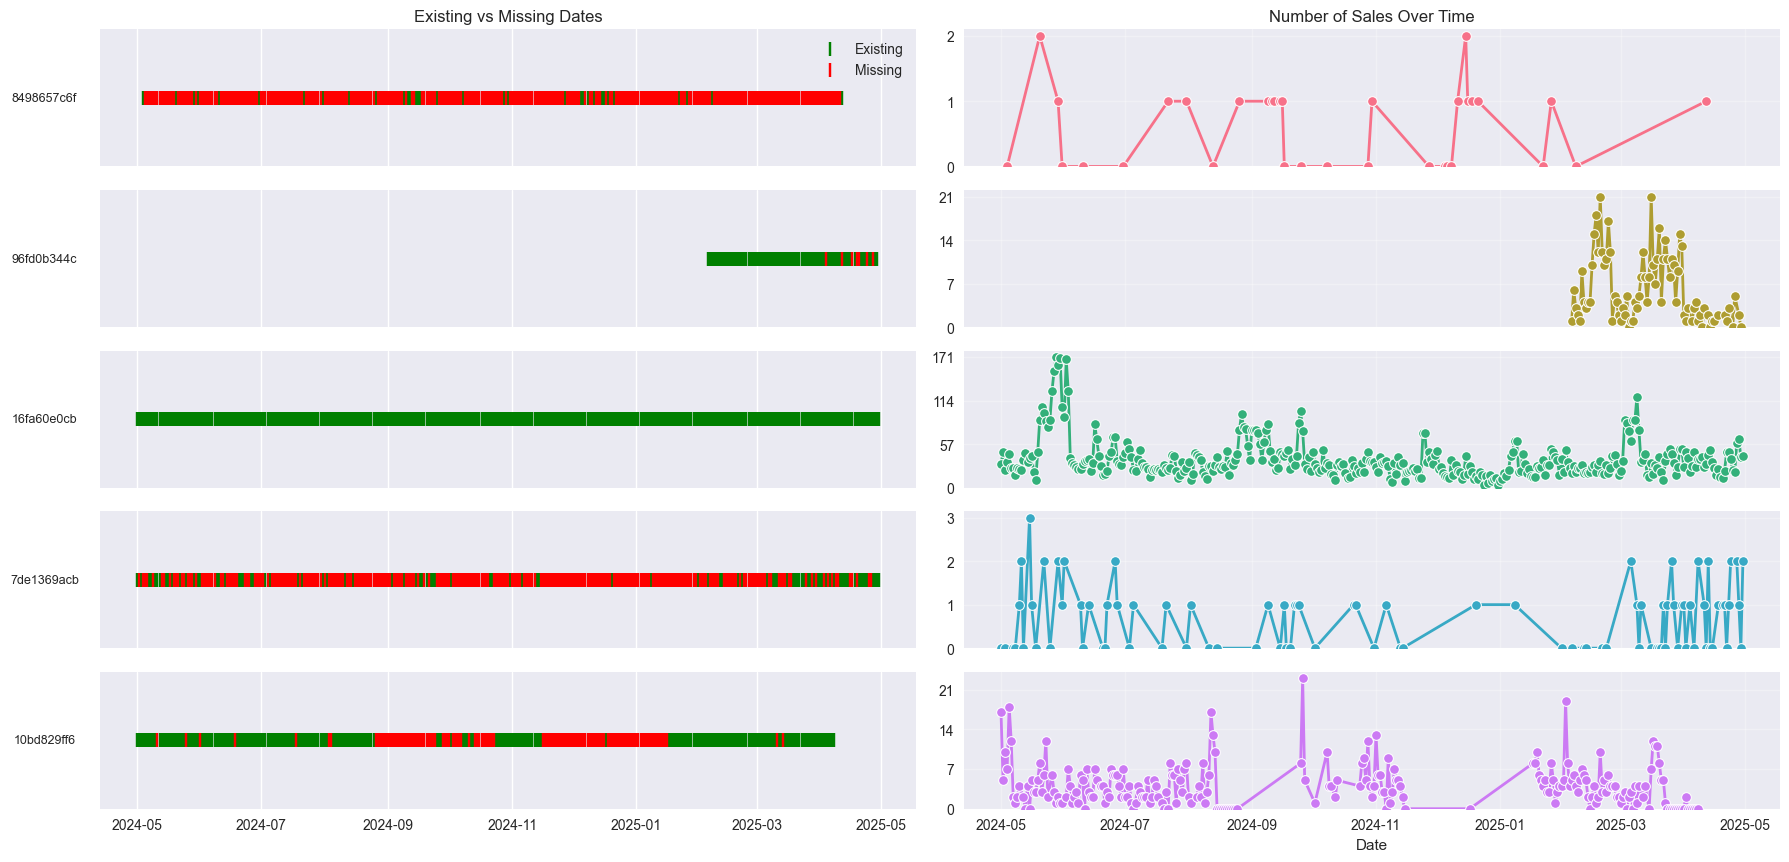

In [30]:
# Sample 5 random identifiers
sample_ids = missing_df["identifier"].dropna().sample(5, random_state=777).tolist()


fig, axes = plt.subplots(5, 2, figsize=(18, 9), sharex="col")
palette = sns.color_palette("husl", 5)


for i, identifier in enumerate(sample_ids):
    # --- Left plot: Existing vs Missing dates ---
    row = missing_df[missing_df["identifier"] == identifier].iloc[0]
    start, end = row["min"], row["max"]

    existing_dates = set(df[df["identifier"] == identifier]["date"])
    all_dates = pd.date_range(start, end)
    missing_dates = set(all_dates) - existing_dates

    # Plot existing dates (green) and missing dates (red) for this identifier
    axes[i, 0].scatter(
        [d for d in all_dates if d in existing_dates],
        [1] * len(existing_dates),
        color="green",
        label="Existing",
        marker="|",
        s=100,
    )
    axes[i, 0].scatter(
        [d for d in all_dates if d in missing_dates],
        [1] * len(missing_dates),
        color="red",
        label="Missing",
        marker="|",
        s=100,
    )

    axes[i, 0].set_yticks([])
    axes[i, 0].set_ylabel(identifier, rotation=0, labelpad=40, fontsize=9, va="center")
    if i == 0:
        axes[i, 0].legend(loc="upper right")
    if i == 0:
        axes[i, 0].set_title("Existing vs Missing Dates")

    # --- Right plot: Number of sales over time ---
    sales_data = df[df["identifier"] == identifier].sort_values("date")
    sns.lineplot(
        ax=axes[i, 1],
        data=sales_data,
        x="date",
        y="n_sold",
        marker="o",
        color=palette[i % 5],
        linewidth=2,
    )

    axes[i, 1].set_ylabel("")
    axes[i, 1].set_yticks(
        np.arange(
            0, sales_data["n_sold"].max() + 1, max(1, sales_data["n_sold"].max() // 3)
        )
    )
    axes[i, 1].set_ylim(bottom=0)
    axes[i, 1].grid(True, alpha=0.3)
    if i == 0:
        axes[i, 1].set_title("Number of Sales Over Time")


plt.xlabel("Date")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Fill in missing dates with n_sold = 0, is_discounted = False

In [31]:
# Create a DataFrame with all expected (identifier, date) pairs
all_dates_df = (
    date_ranges.set_index("identifier")
    .apply(lambda row: pd.date_range(row["min"], row["max"]), axis=1)
    .explode()
    .reset_index()
    .rename(columns={0: "date"})
)

# Merge with existing data to find missing rows
merged = all_dates_df.merge(
    df,
    on=["identifier", "date"],
    how="left",
    suffixes=("", "_orig"),
)

# Fill missing values for n_sold, is_discounted, and category
merged["n_sold"] = merged["n_sold"].fillna(0).astype(int)
merged["is_discounted"] = merged["is_discounted"].fillna(False)
# Fill category from missing_df (which has identifier-category mapping)
merged = merged.merge(
    missing_df[["identifier", "category"]],
    on="identifier",
    how="left",
    suffixes=("", "_cat"),
)
merged["category"] = merged["category"].fillna(merged["category_cat"])
merged = merged.drop(columns=["category_cat"])

# Add date features
merged["week"] = ((merged["date"] - week1_start).dt.days // 7 + 1).clip(lower=1)
merged["is_holiday"] = merged["date"].isin(swedish_holidays.index)

# Reorder columns to match original
train_filled = (
    merged[
        [
            "identifier",
            "date",
            "n_sold",
            "is_discounted",
            "category",
            "week",
            "is_holiday",
        ]
    ]
    .sort_values(["identifier", "date"])
    .reset_index(drop=True)
)

train_filled.head()

C:\Users\Dealan\AppData\Local\Temp\ipykernel_7136\1467984975.py:33: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  merged["is_holiday"] = merged["date"].isin(swedish_holidays.index)


,identifier,date,n_sold,is_discounted,category,week,is_holiday
0,00119a49e3,2024-10-04,0,False,71e3583839,23,False
1,00119a49e3,2024-10-05,0,False,71e3583839,23,False
2,00119a49e3,2024-10-06,3,False,71e3583839,23,False
3,00119a49e3,2024-10-07,0,False,71e3583839,23,False
4,00119a49e3,2024-10-08,2,False,71e3583839,23,False


# Aggregate Train Data from Daily to Weekly

In [32]:
# Aggregate sales and prepare for discount aggregation
weekly_agg = (
    train_filled.groupby(["identifier", "week", "category"])
    .agg(
        {
            "n_sold": "sum",
            "is_discounted": "any",  # Will be True if any day in week is discounted
            "is_holiday": "any",
        }
    )
    .reset_index()
    .rename(
        columns={"is_holiday": "contains_holiday", "is_discounted": "contains_discount"}
    )
)

# Calculate the first week for each identifier
first_week = weekly_agg.groupby("identifier")["week"].transform("min")

# Calculate weeks since launch
weekly_agg["weeks_since_launch"] = weekly_agg["week"] - first_week
weekly_agg["weeks_since_last_discount"] = (
    weekly_agg.groupby("identifier")
    .apply(lambda group: group.loc[group["contains_discount"], "week"].max())
    .reset_index(level=0, drop=True)
)
weekly_agg.head(5)

C:\Users\Dealan\AppData\Local\Temp\ipykernel_7136\3383918472.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.loc[group["contains_discount"], "week"].max())


,identifier,week,category,n_sold,contains_discount,contains_holiday,weeks_since_launch,weeks_since_last_discount
0,00119a49e3,23,71e3583839,5,False,False,0,51.0
1,00119a49e3,24,71e3583839,8,False,False,1,47.0
2,00119a49e3,25,71e3583839,6,False,False,2,47.0
3,00119a49e3,26,71e3583839,20,True,False,3,20.0
4,00119a49e3,27,71e3583839,56,True,True,4,50.0


In [33]:
def find_most_recent_discount_week(group):
    # Initialize a list to store the most recent discount week for each row
    recent_discount_weeks = []

    # Track the most recent discount week
    weeks_since_last_discsount = None
    most_recent_discounted_week = None
    # Iterate over each row in the group
    for _, row in group.iterrows():
        if row["contains_discount"]:
            most_recent_discounted_week = row["week"]
            weeks_since_last_discsount = 0
        else:
            if most_recent_discounted_week is None:
                weeks_since_last_discsount = 52
            else:
                weeks_since_last_discsount = row["week"] - most_recent_discounted_week
        recent_discount_weeks.append(weeks_since_last_discsount)

    return pd.Series(recent_discount_weeks, index=group.index)


weekly_agg["weeks_since_last_discount"] = weekly_agg.groupby(
    "identifier", group_keys=False
).apply(find_most_recent_discount_week)


def find_most_recent_holiday_week(group):
    recent_holiday_weeks = []
    most_recent_holiday_week = None
    for _, row in group.iterrows():
        if row["contains_holiday"]:
            most_recent_holiday_week = row["week"]
            weeks_since_last_holiday = 0
        else:
            if most_recent_holiday_week is None:
                weeks_since_last_holiday = (
                    52  # Assuming 52 weeks in a year as a large number
                )
            else:
                weeks_since_last_holiday = row["week"] - most_recent_holiday_week
        recent_holiday_weeks.append(weeks_since_last_holiday)
    return pd.Series(recent_holiday_weeks, index=group.index)


# Apply the function to each group for holidays
weekly_agg["weeks_since_last_holiday"] = weekly_agg.groupby(
    "identifier", group_keys=False
).apply(find_most_recent_holiday_week)

C:\Users\Dealan\AppData\Local\Temp\ipykernel_7136\2898883263.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(find_most_recent_discount_week)
C:\Users\Dealan\AppData\Local\Temp\ipykernel_7136\2898883263.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weekly_agg["weeks_since_last_holiday"] = weekly_agg.groupby("identifier", group_keys=False).apply(find_most_recent_holiday_week)


In [34]:
weekly_agg.head(20)

,identifier,week,category,n_sold,contains_discount,contains_holiday,weeks_since_launch,weeks_since_last_discount,weeks_since_last_holiday
0,00119a49e3,23,71e3583839,5,False,False,0,52,52
1,00119a49e3,24,71e3583839,8,False,False,1,52,52
2,00119a49e3,25,71e3583839,6,False,False,2,52,52
3,00119a49e3,26,71e3583839,20,True,False,3,0,52
4,00119a49e3,27,71e3583839,56,True,True,4,0,0
5,00119a49e3,28,71e3583839,35,True,False,5,0,1
6,00119a49e3,29,71e3583839,2,False,False,6,1,2
7,00119a49e3,30,71e3583839,4,True,False,7,0,3
8,00119a49e3,31,71e3583839,5,True,False,8,0,4
9,00119a49e3,32,71e3583839,3,False,False,9,1,5


# Plot Sales by Week Since Last Discount / Holiday

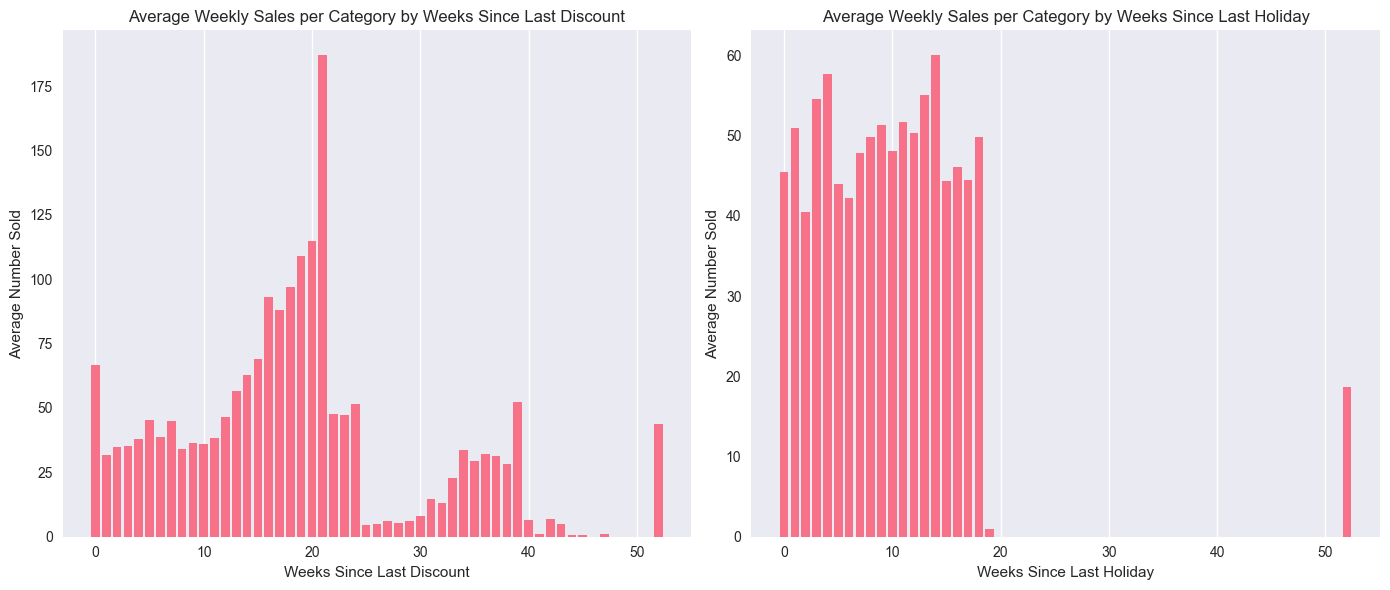

In [ ]:
# Calculate average weekly sales per category based on weeks_since_last_discount and weeks_since_last_holiday
avg_sales_discount = (
    weekly_agg.groupby("weeks_since_last_discount")["n_sold"].mean().reset_index()
)
avg_sales_holiday = (
    weekly_agg.groupby("weeks_since_last_holiday")["n_sold"].mean().reset_index()
)

# Plot the average weekly sales for each category over weeks_since_last_discount and weeks_since_last_holiday
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot for weeks_since_last_discount
ax[0].bar(avg_sales_discount["weeks_since_last_discount"], avg_sales_discount["n_sold"])
ax[0].set_title("Average Weekly Sales by Weeks Since Last Discount")
ax[0].set_xlabel("Weeks Since Last Discount")
ax[0].set_ylabel("Average Number Sold")
ax[0].grid(axis="y")

# Plot for weeks_since_last_holiday
ax[1].bar(avg_sales_holiday["weeks_since_last_holiday"], avg_sales_holiday["n_sold"])
ax[1].set_title("Average Weekly Sales by Weeks Since Last Holiday")
ax[1].set_xlabel("Weeks Since Last Holiday")
ax[1].set_ylabel("Average Number Sold")
ax[1].grid(axis="y")

plt.tight_layout()
plt.show()

# Plot Category Stats

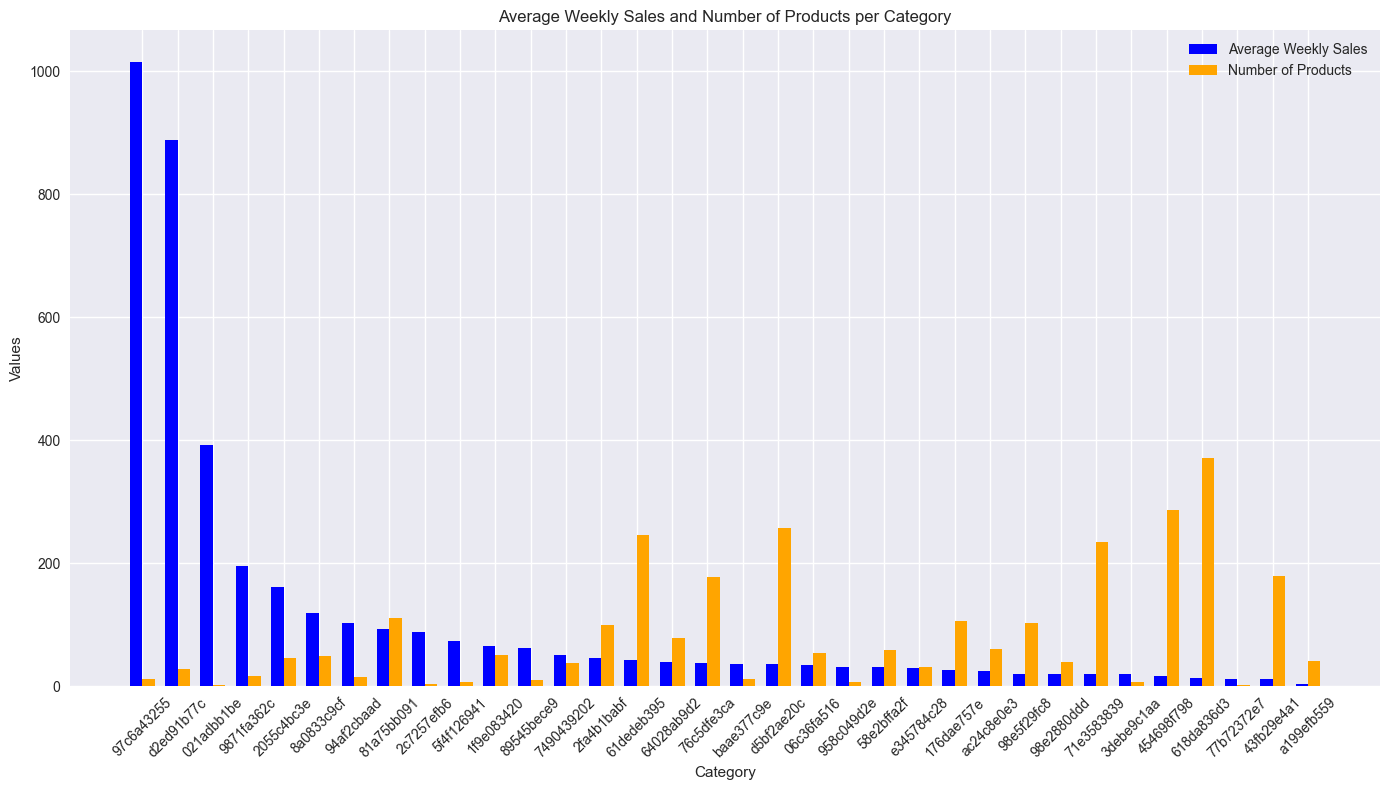

In [35]:
category_counts = (
    (
        categories.groupby("category")["identifier"]
        .nunique()
        .sort_values(ascending=False)
    )
    .to_frame()
    .reset_index()
)
average_weekly_sales = (
    (weekly_agg.groupby("category")["n_sold"].mean().sort_values(ascending=False))
    .to_frame()
    .reset_index()
)

# Merge the two DataFrames on the 'category' column
combined_data = pd.merge(average_weekly_sales, category_counts, on="category")

# Set the positions and width for the bars
positions = np.arange(len(combined_data["category"]))
width = 0.35

# Create a single plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plot the bars for average weekly sales and number of products
bars1 = ax.bar(
    positions - width / 2,
    combined_data["n_sold"],
    width,
    label="Average Weekly Sales",
    color="blue",
)
bars2 = ax.bar(
    positions + width / 2,
    combined_data["identifier"],
    width,
    label="Number of Products",
    color="orange",
)

# Add labels, title, and legend
ax.set_xlabel("Category")
ax.set_ylabel("Values")
ax.set_title("Average Weekly Sales and Number of Products per Category")
ax.set_xticks(positions)
ax.set_xticklabels(combined_data["category"], rotation=45)
ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

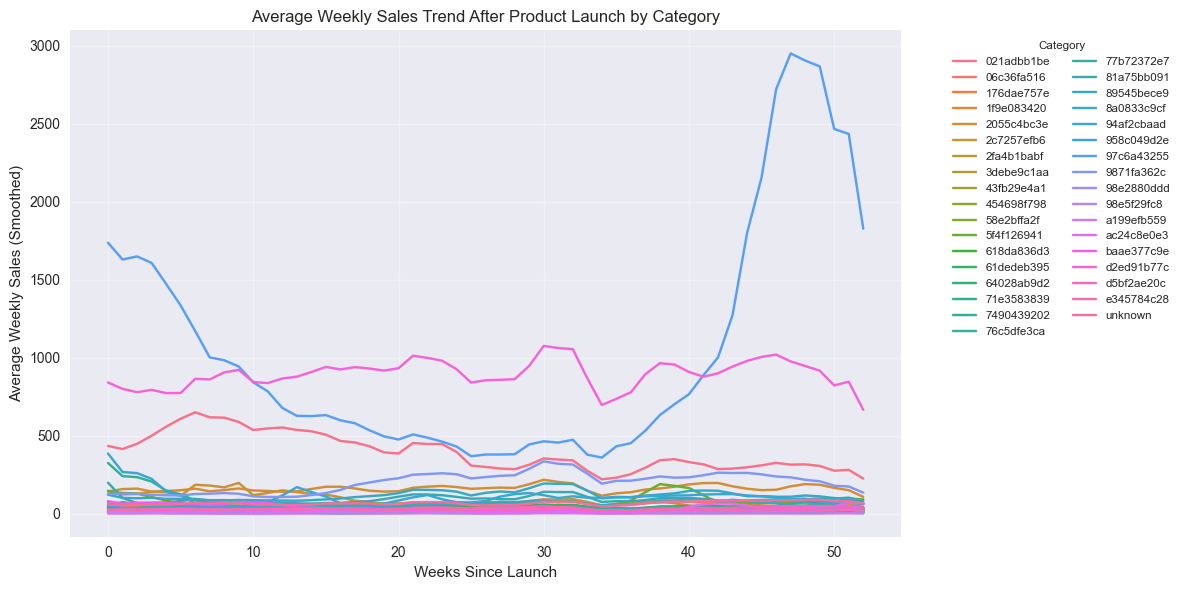

In [36]:
# Calculate mean sales per week since launch for each category
trend = (
    weekly_agg.groupby(["category", "weeks_since_launch"])["n_sold"]
    .mean()
    .reset_index()
)

# Apply a rolling mean for smoothing (window=4 weeks)
trend["smoothed"] = trend.groupby("category")["n_sold"].transform(
    lambda x: x.rolling(window=4, min_periods=1).mean()
)

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=trend, x="weeks_since_launch", y="smoothed", hue="category", errorbar=None
)
plt.title("Average Weekly Sales Trend After Product Launch by Category")
plt.xlabel("Weeks Since Launch")
plt.ylabel("Average Weekly Sales (Smoothed)")
plt.legend(
    title="Category",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    ncol=2,  # Use 2 columns to reduce vertical space
    fontsize="small",
    title_fontsize="small",
)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

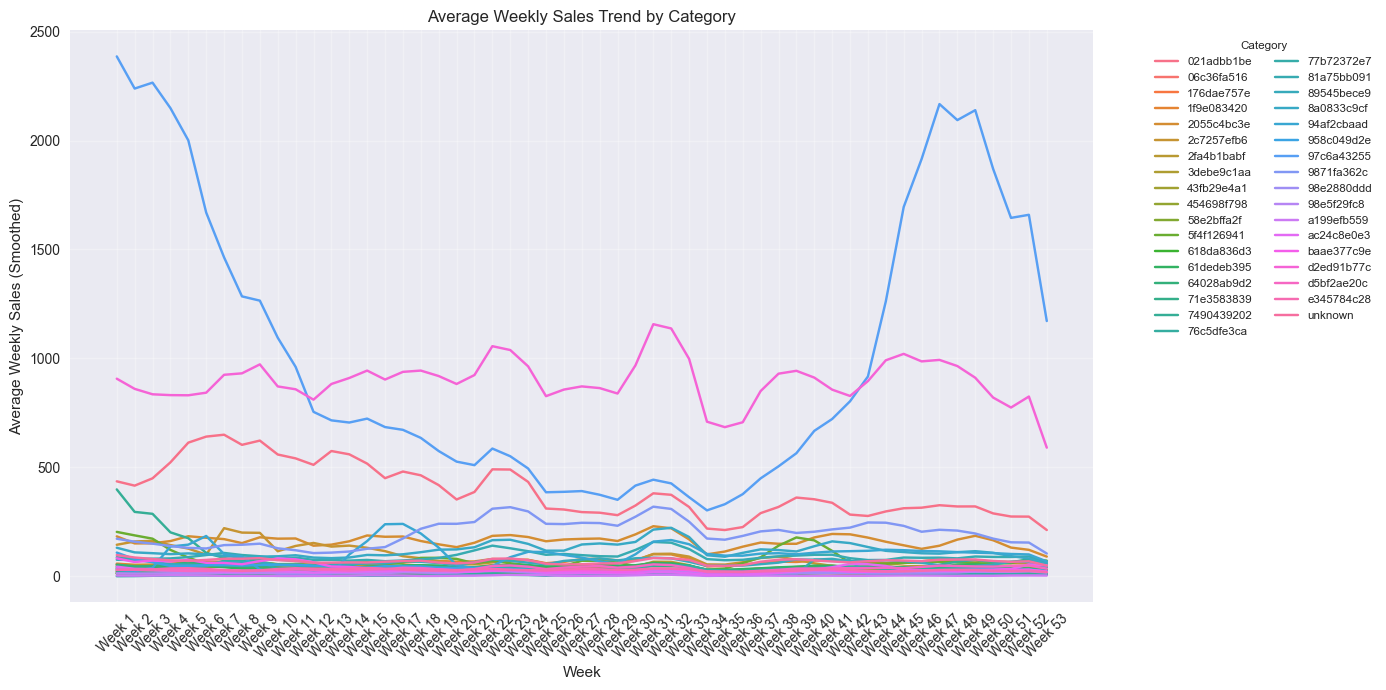

In [37]:
# Calculate mean sales per week for each category
weekly_trend = weekly_agg.groupby(["category", "week"])["n_sold"].mean().reset_index()

# Apply a rolling mean for smoothing (window=3 weeks) within each category
weekly_trend["smoothed"] = weekly_trend.groupby("category")["n_sold"].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Map week numbers to a string representation for better readability
weekly_trend["week_name"] = weekly_trend["week"].apply(lambda x: f"Week {x}")

# Convert week_name to a categorical type with ordered weeks
weekly_trend["week_name"] = pd.Categorical(
    weekly_trend["week_name"],
    categories=[
        f"Week {i}"
        for i in range(weekly_trend["week"].min(), weekly_trend["week"].max() + 1)
    ],
    ordered=True,
)

# Plot the smoothed weekly sales trend by category
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=weekly_trend, x="week_name", y="smoothed", hue="category", errorbar=None
)
plt.title("Average Weekly Sales Trend by Category")
plt.xlabel("Week")
plt.ylabel("Average Weekly Sales (Smoothed)")
plt.legend(
    title="Category",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    ncol=2,  # Use 2 columns to reduce vertical space
    fontsize="small",
    title_fontsize="small",
)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

# Relative change in sales during discounts by category

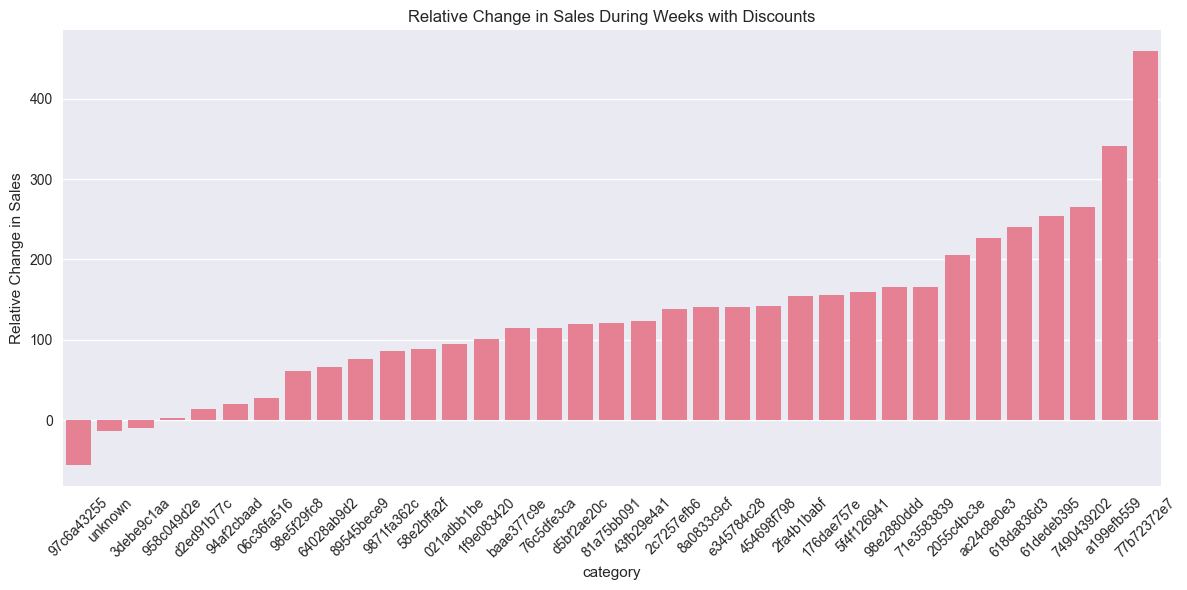

In [38]:
# Calculate the relative change in sales during discounts by category
discount_impact = (
    weekly_agg.groupby("category")
    .apply(
        lambda x: (
            x[x["contains_discount"]]["n_sold"].mean()
            - x[~x["contains_discount"]]["n_sold"].mean()
        )
        / x[~x["contains_discount"]]["n_sold"].mean()
        * 100,
        include_groups=False,
    )
    .sort_values()
)


plt.figure(figsize=(12, 6))


sns.barplot(x=discount_impact.index, y=discount_impact.values)


plt.title("Relative Change in Sales During Weeks with Discounts")
plt.ylabel("Relative Change in Sales")


plt.xticks(rotation=45)


plt.tight_layout()


plt.show()

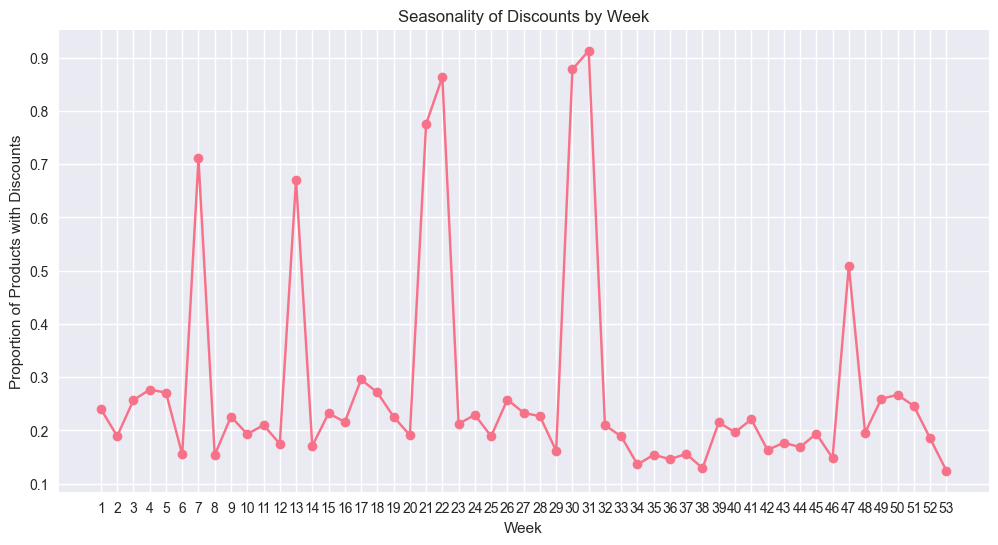

In [39]:
# Convert 'contains_discount' to integer for easier aggregation
weekly_agg["contains_discount_int"] = weekly_agg["contains_discount"].astype(int)

# Group by week and calculate the mean of 'contains_discount'
weekly_discount_seasonality = (
    weekly_agg.groupby("week")["contains_discount_int"].mean().reset_index()
)

# Plot the seasonality of discounts by week
plt.figure(figsize=(12, 6))
plt.plot(
    weekly_discount_seasonality["week"],
    weekly_discount_seasonality["contains_discount_int"],
    marker="o",
)
plt.title("Seasonality of Discounts by Week")
plt.xlabel("Week")
plt.ylabel("Proportion of Products with Discounts")
plt.xticks(weekly_discount_seasonality["week"])
plt.grid(True)
plt.show()

# Relative change in sales during weeks containing a holiday


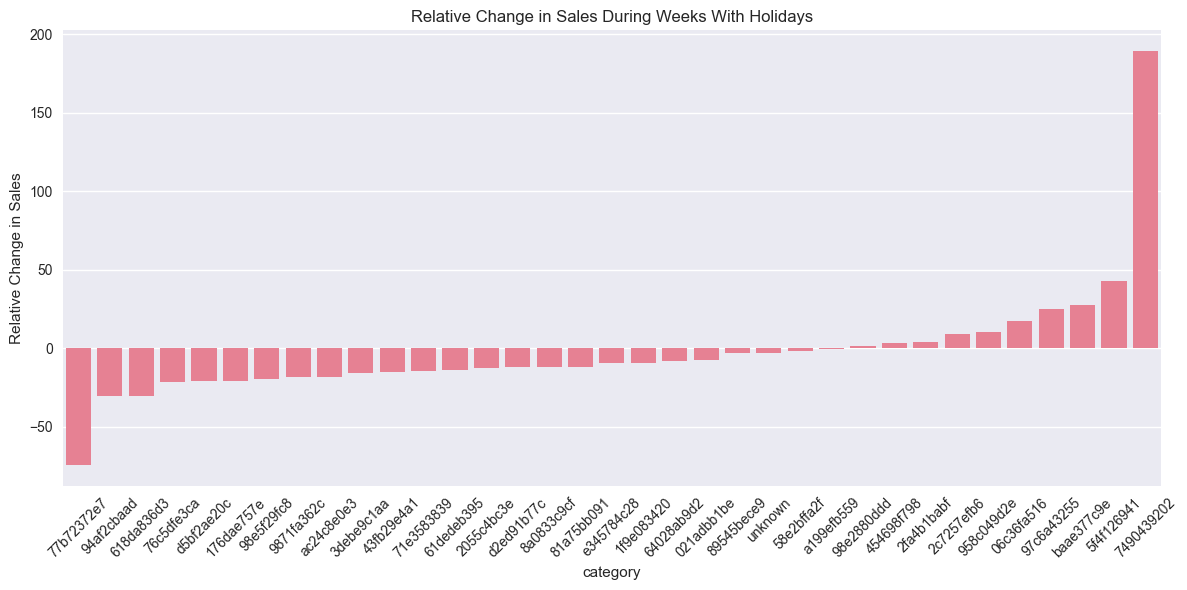

In [40]:
# Calculate the relative change in sales during weeks containing a holiday by category
holiday_impact = (
    weekly_agg.groupby("category")
    .apply(
        lambda x: (
            x[x["contains_holiday"]]["n_sold"].mean()
            - x[~x["contains_holiday"]]["n_sold"].mean()
        )
        / x[~x["contains_holiday"]]["n_sold"].mean()
        * 100,
        include_groups=False,
    )
    .sort_values()
)


plt.figure(figsize=(12, 6))


sns.barplot(x=holiday_impact.index, y=holiday_impact.values)


plt.title("Relative Change in Sales During Weeks With Holidays")
plt.ylabel("Relative Change in Sales")


plt.xticks(rotation=45)
plt.tight_layout()


plt.show()

# Calculate correlation between holidays and discounts

In [41]:
# Convert 'contains_discount' and 'contains_holiday' to integers for correlation calculation
weekly_agg["contains_discount_int"] = weekly_agg["contains_discount"].astype(int)
weekly_agg["contains_holiday_int"] = weekly_agg["contains_holiday"].astype(int)

# Calculate the correlation matrix
correlation_matrix = weekly_agg[
    ["contains_discount_int", "contains_holiday_int"]
].corr()

# Extract the correlation value between 'contains_discount_int' and 'contains_holiday_int'
correlation_value = correlation_matrix.loc[
    "contains_discount_int", "contains_holiday_int"
]

print(
    f"Correlation between discounts and holidays on a weekly level: {correlation_value:.2f}"
)

# Convert 'contains_discount' and 'contains_holiday' to integers for correlation calculation
train_filled["is_discounted_int"] = train_filled["is_discounted"].astype(int)
train_filled["is_holiday_int"] = train_filled["is_holiday"].astype(int)

# Calculate the correlation matrix
correlation_matrix = train_filled[["is_discounted_int", "is_holiday_int"]].corr()

# Extract the correlation value between 'is_discounted_int' and 'is_holiday_int'
correlation_value = correlation_matrix.loc["is_discounted_int", "is_holiday_int"]

print(
    f"Correlation between discounts and holidays on a daily level:  {correlation_value:.2f}"
)

Correlation between discounts and holidays on a weekly level: -0.09
Correlation between discounts and holidays on a daily level:  -0.03


# Add weeks_since_last_discount and weekes_since_last_holiday features

In [46]:
# Add year, month, week to test set
test["period_start"] = pd.to_datetime(test["period_start"])
test["week"] = ((test["period_start"] - week1_start).dt.days // 7 + 1).clip(lower=1)

max_weeks_since_launch = weekly_agg.groupby("identifier")["weeks_since_launch"].max()

# Update the test DataFrame
test["weeks_since_launch"] = test["identifier"].map(max_weeks_since_launch) + 1
test["weeks_since_last_holiday"] = 0  # First of May is a holiday

max_week_rows = weekly_agg.loc[weekly_agg.groupby("identifier")["week"].idxmax()]

# Extract the 'weeks_since_last_discount' value from these rows
max_weeks_since_last_discount = max_week_rows.set_index("identifier")[
    "weeks_since_last_discount"
]
test["weeks_since_last_discount"] = test["identifier"].map(
    max_weeks_since_last_discount + 1
)
test.head(10)

,identifier,period_start,period_end,category,week,weeks_since_launch,weeks_since_last_holiday,weeks_since_last_discount
0,00119a49e3,2025-05-01,2025-05-07,71e3583839,53,30,0,2
1,001630a8c1,2025-05-01,2025-05-07,d2ed91b77c,53,53,0,7
2,009419bbaf,2025-05-01,2025-05-07,43fb29e4a1,53,52,0,3
3,00a179934c,2025-05-01,2025-05-07,98e5f29fc8,53,53,0,4
4,0106a86d3b,2025-05-01,2025-05-07,71e3583839,53,37,0,8
5,01115386c1,2025-05-01,2025-05-07,618da836d3,53,51,0,4
6,0112d42550,2025-05-01,2025-05-07,71e3583839,53,52,0,1
7,01223f695c,2025-05-01,2025-05-07,81a75bb091,53,53,0,3
8,012dfc7ad0,2025-05-01,2025-05-07,81a75bb091,53,53,0,3
9,0138bb2c68,2025-05-01,2025-05-07,43fb29e4a1,53,53,0,1


# Save processed datasets to parquet files

In [44]:
parquet_path = "processed_data/train.parquet"
output_dir = Path("predictions")
output_dir.mkdir(exist_ok=True)
weekly_agg.to_parquet("processed_data/train.parquet", index=False)
test.to_parquet("processed_data/test.parquet", index=False)